In [61]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model
from haloclustering.data import get_combined_dataset, make_grid_data
import haloclustering.evalulate_model as evaluate
import numpy as np
import matplotlib.pyplot as plt
import corner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load in combined CGM$^2$ + CASBaH

In [24]:
cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
data = get_combined_dataset(cgmsqfile, casdir)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1389
misses 5509
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 291


In [25]:
# r0, gamma, r0_2, gamma_2, beta1, beta2, beta2h, dndz_index, dndz_coeff = params

r_0 = 3 # clustering scale
r_0_2 = 4
beta_1_initial = 0.5
beta_2h_initial = 0.05
gamma_initial = 6 # clutering powerlaw index
gamma_2_initial = 1.6
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 27
initial = np.array([r_0, gamma_initial, r_0_2, gamma_2_initial, beta_1_initial, beta_2h_initial, dndz_index, dndz_coeff])
bounds = ((0, 10), (1, 10), (0, 10), (1, 5), (-3, 3), (-3, 3), (-3, 3), (0, 35))

In [26]:
model = Model(data, m0=10**9.5)

(array([  57.,  159.,  341.,  561., 1049., 1579., 1963., 1292.,  435.,
          21.]),
 array([ 7.01130468,  7.44276525,  7.87422582,  8.30568639,  8.73714696,
         9.16860753,  9.6000681 , 10.03152867, 10.46298924, 10.89444981,
        11.32591038]),
 <BarContainer object of 10 artists>)

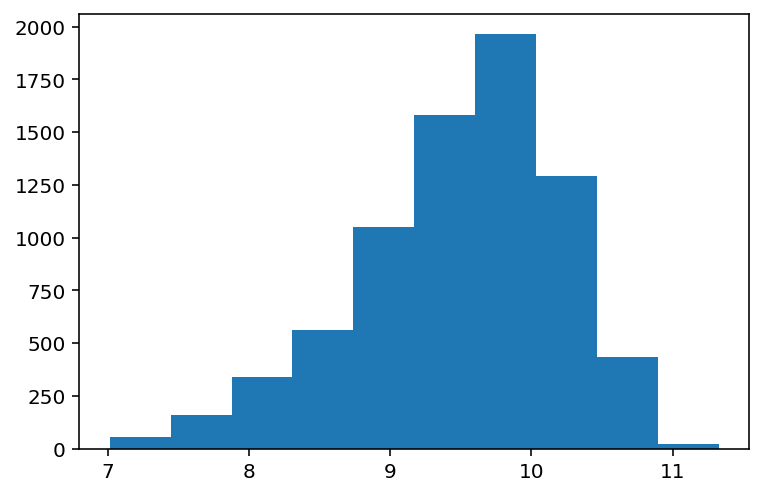

In [43]:
plt.hist(np.log10(model.mass))

In [9]:
soln = evaluate.max_likelihood_est(model, initial, bounds)
r0, gamma, r0_2, gamma_2, beta1, beta2h, dndz_index, dndz_coeff = soln.x

print('\n')
print("Maximum likelihood estimates:")
print("=============================")
print("r0 = {0:.3f}".format(r0))
print("r0_2 = {0:.3f}".format(r0_2))
print("gamma = {0:.3f}".format(gamma))
print("gamma_2 = {0:.3f}".format(gamma_2))
print("beta1 = {0:.3f}".format(beta1))
print("beta2h = {0:.3f}".format(beta2h))
print('dndz_index = {0:.3f}'.format(dndz_index))
print('dndz_index = {0:.3f}'.format(dndz_coeff))
print("=============================")



Maximum likelihood estimates:
r0 = 1.627
r0_2 = 4.222
gamma = 2.312
gamma_2 = 1.000
beta1 = 0.161
beta2h = -0.059
dndz_index = 1.252
dndz_index = 22.938


In [10]:

# sampler = evaluate.posterior_sampler(soln, model.log_probability, nsteps=4000)

100%|██████████| 4000/4000 [07:48<00:00,  8.53it/s]


In [33]:
# r0, gamma, r0_2, gamma_2, beta1, beta2h, dndz_index, dndz_coef
bounds = np.array([[0, 1, 2, 1, -1, -1, 0, 10], 
                    [2, 5, 6, 3, 1, 1, 2, 30]])

sampler = evaluate.posterior_sampler_uniform_start(bounds, model.log_probability, nsteps=4000)

100%|██████████| 4000/4000 [08:59<00:00,  7.42it/s]


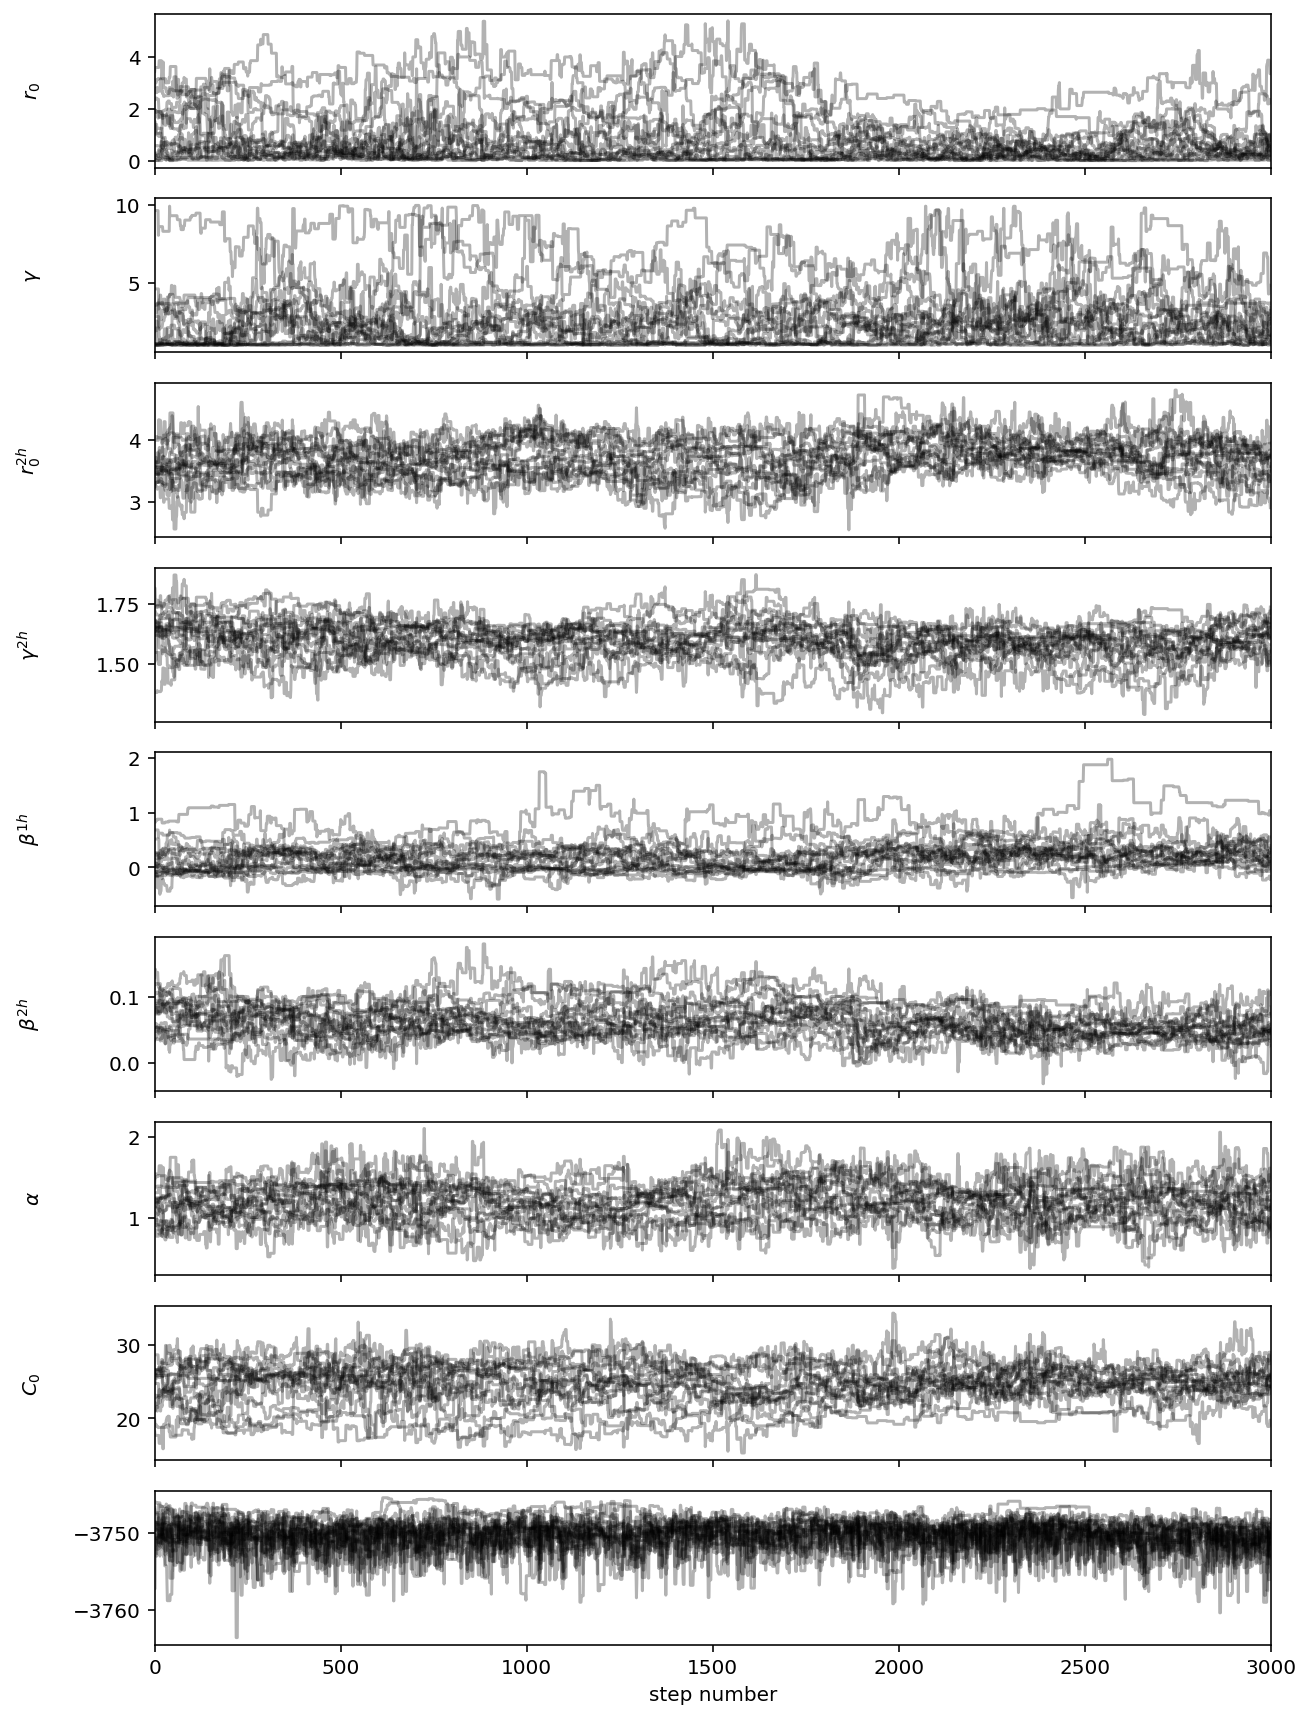

In [39]:
discard = 1000
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)

ndim = samples.shape[2]

# plot
# r0, gamma, r0_2, gamma_2, beta1, beta2, beta2h, dndz_index, dndz_coeff
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 15), sharex=True)
labels = [r"$r_{0}$", r"$\gamma$", r"$r_0^{2h}$", r"$\gamma^{2h}$", r"$\beta^{1h}$", r"$\beta^{2h}$", r"$\alpha$", r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

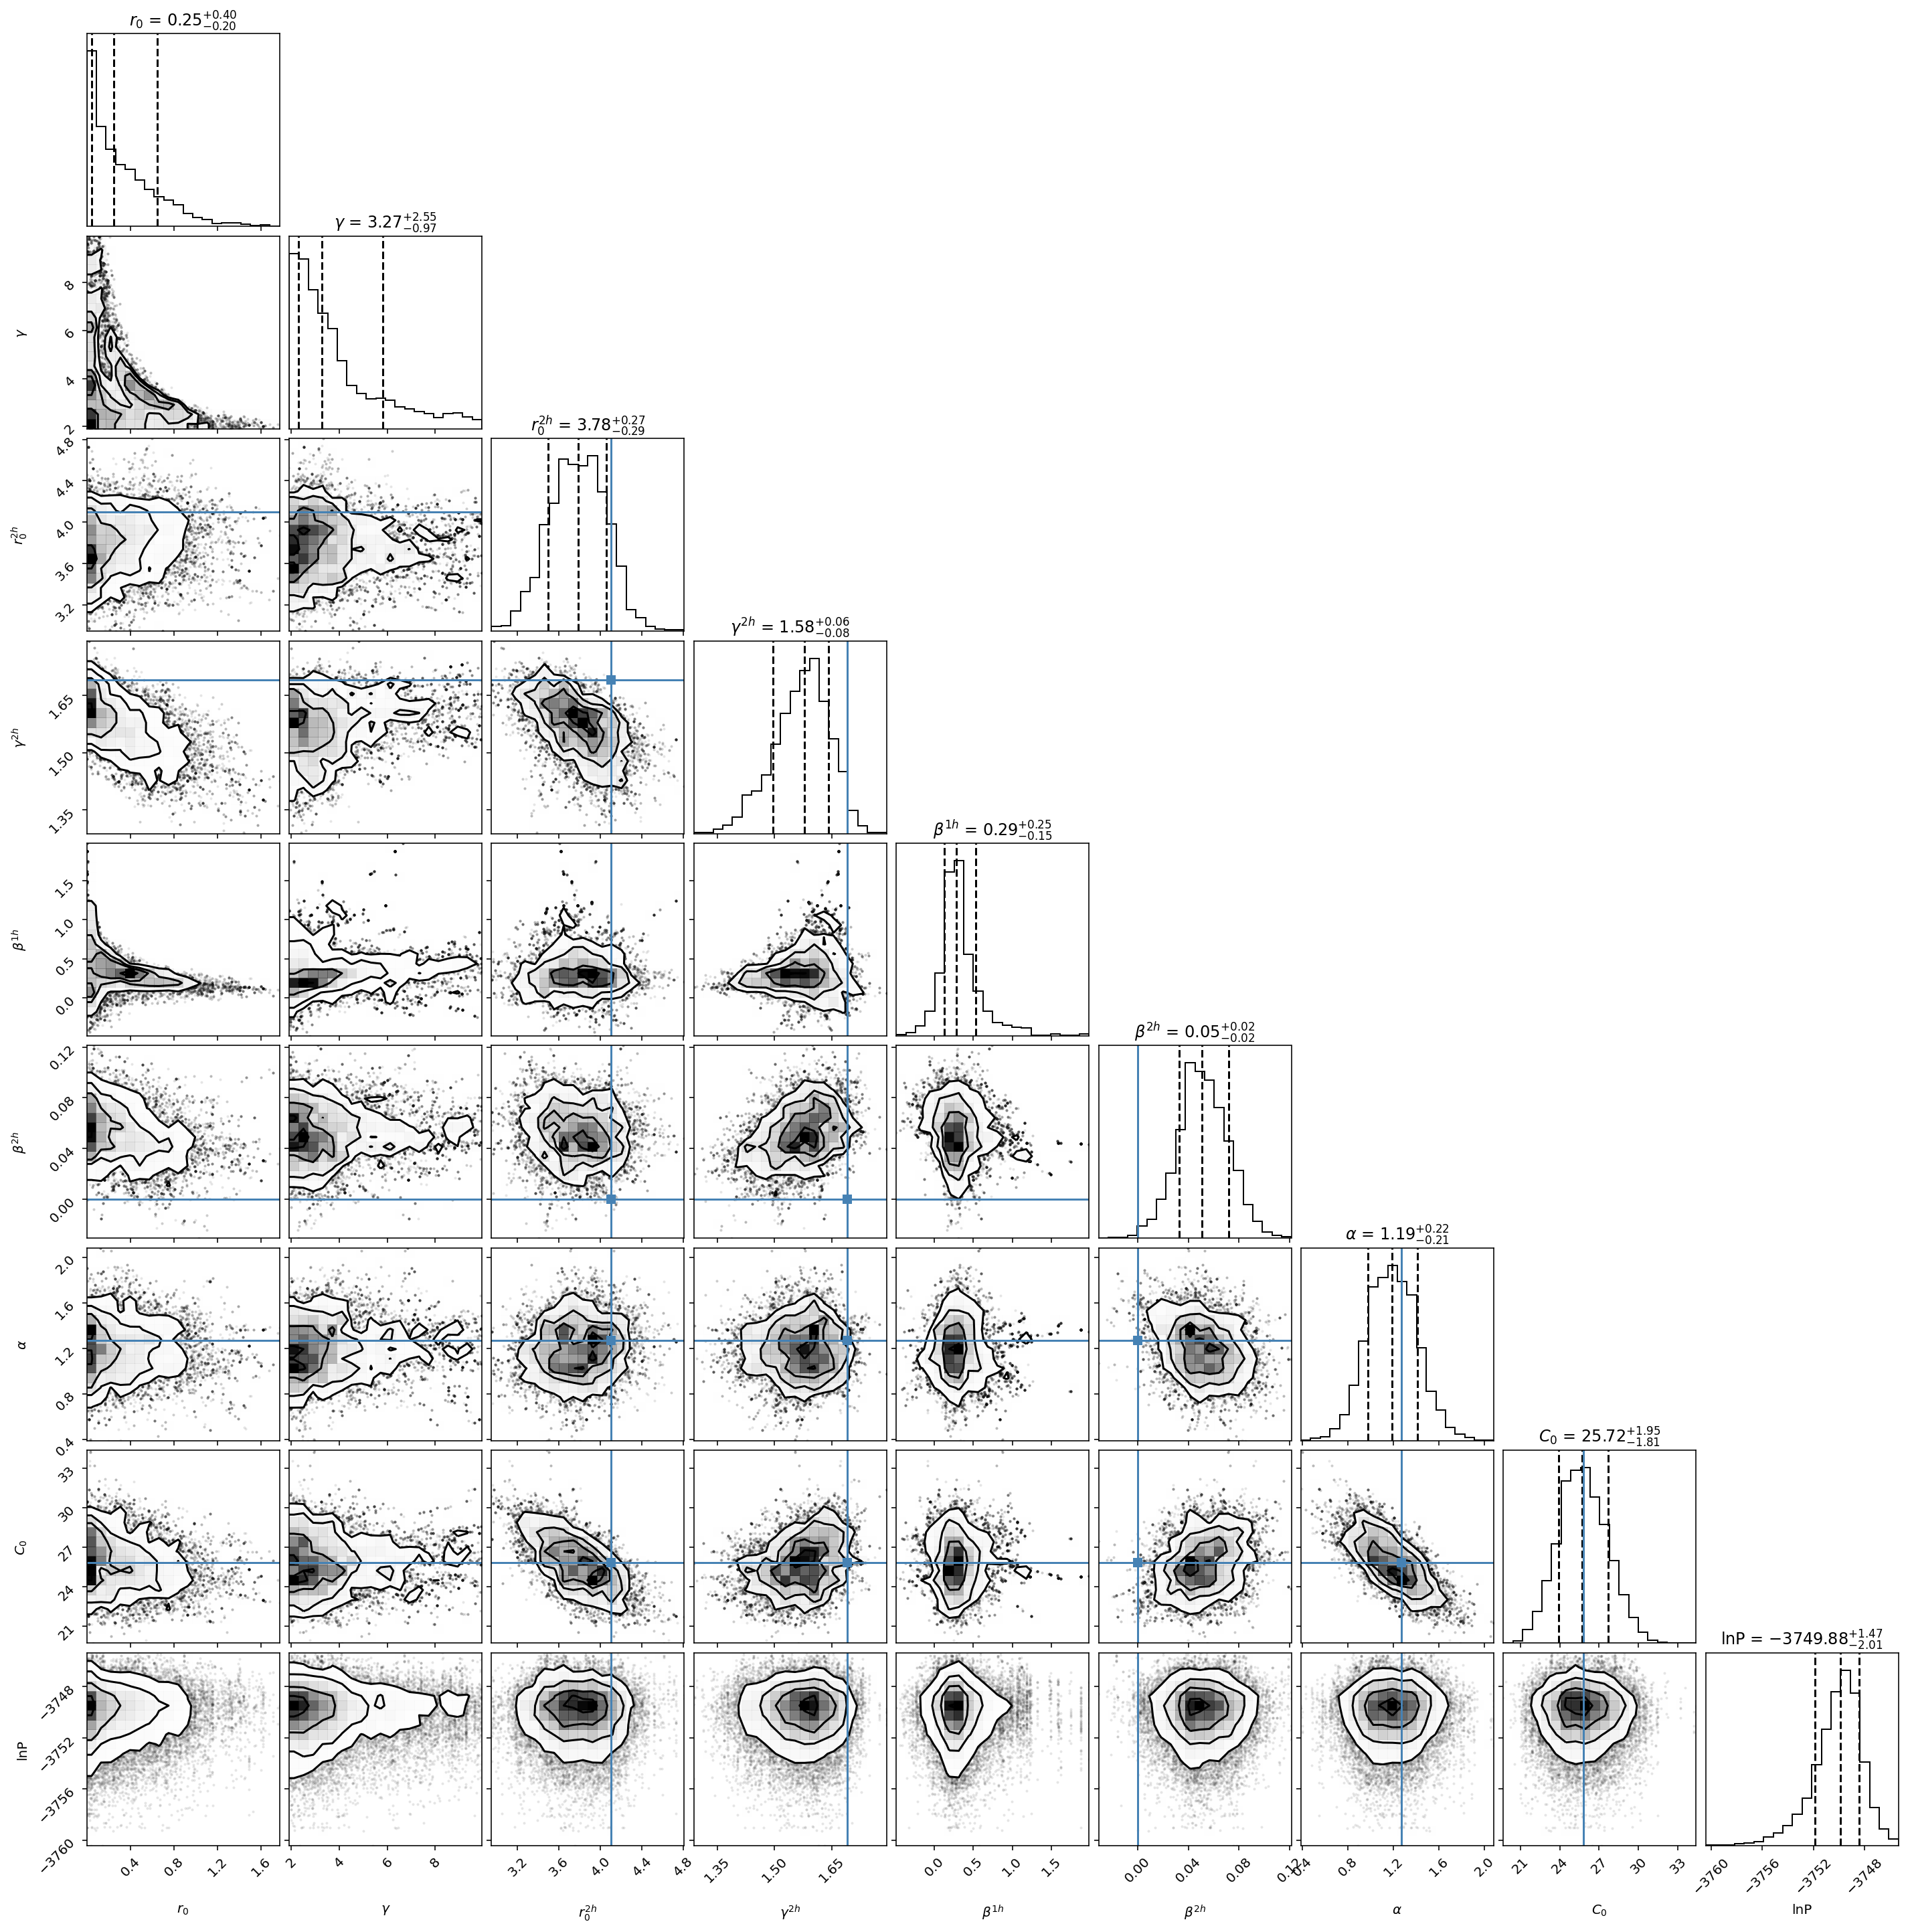

In [52]:
lnprob = sampler.lnprobability[:,discard:].ravel()
flt_w_likelihood = np.concatenate([flat_samples, lnprob[:, None]], axis=1)
nolo_gamma_mask = flt_w_likelihood[:,1] > 1.9

new_flat = flt_w_likelihood[nolo_gamma_mask]
fig = corner.corner(
    new_flat, labels=labels+['lnP'], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, 
    truths=[None, None, 4.1, 1.69, None, 0, 1.27, 25.8, None]
);



In [53]:
plt.scatter(np.log10(data[2]), np.log10(data[7]),s=1)
# plt.axline((9, 2), slope=1/8)
# plt.axline((9, 2), slope=0.5) # beta1h 1 
# plt.axline((10.5, 2.5), slope=0.05) # beta 1h 2
mline_lo = np.logspace(7,10.5)
mline_hi = np.logspace(10.5,11)

def rline(r0, beta, mline):
    m0 = 10**10.5
    return np.log10(r0*(mline/m0)**beta) + 3

asample = new_flat[:1000].T
r0sample = asample[0]
beta1sample = asample[4]
beta2sample = asample[5]
plt.plot(np.log10(mline_lo), rline(r0sample, beta1sample, mline_lo[:, None]), lw=0.5)
plt.plot(np.log10(mline_hi), rline(r0sample, beta2sample, mline_hi[:, None]))

plt.axvline(10.5)
plt.xlabel("log10 M*")
plt.ylabel("log10 Rvir [kpc]")
plt.xlim(6, 11.5)
plt.ylim(0,4);

(0.0, 4.0)

Error in callback <function flush_figures at 0x7f7f80b5e0d0> (for post_execute):


KeyboardInterrupt: 

In [55]:
model.params

array([-0.07362955,  4.00643759,  3.95523498,  1.61278145,  1.25698599,
        0.02995741,  1.19314184, 25.30991244])

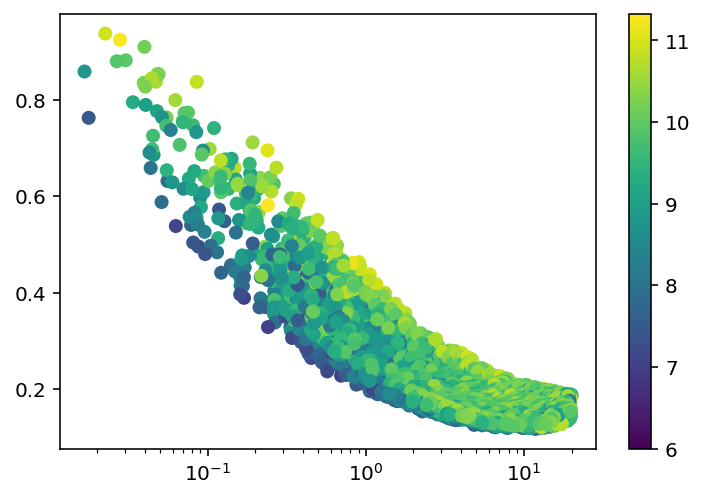

In [59]:

model.set_params(new_flat[20, :-1])

phit1h = model.phit_1halo()
phit2h = model.phit_2halo()



rho_lin = np.linspace(0, 10, len(model.rho_com))

# plt.scatter(model.rho_com, phit1h, c=np.log10(model.mass), vmin=6)
plt.scatter(model.rho_com, phit2h, c=np.log10(model.mass), vmin=6)
plt.colorbar()
plt.xscale('log')
# plt.yscale('log')


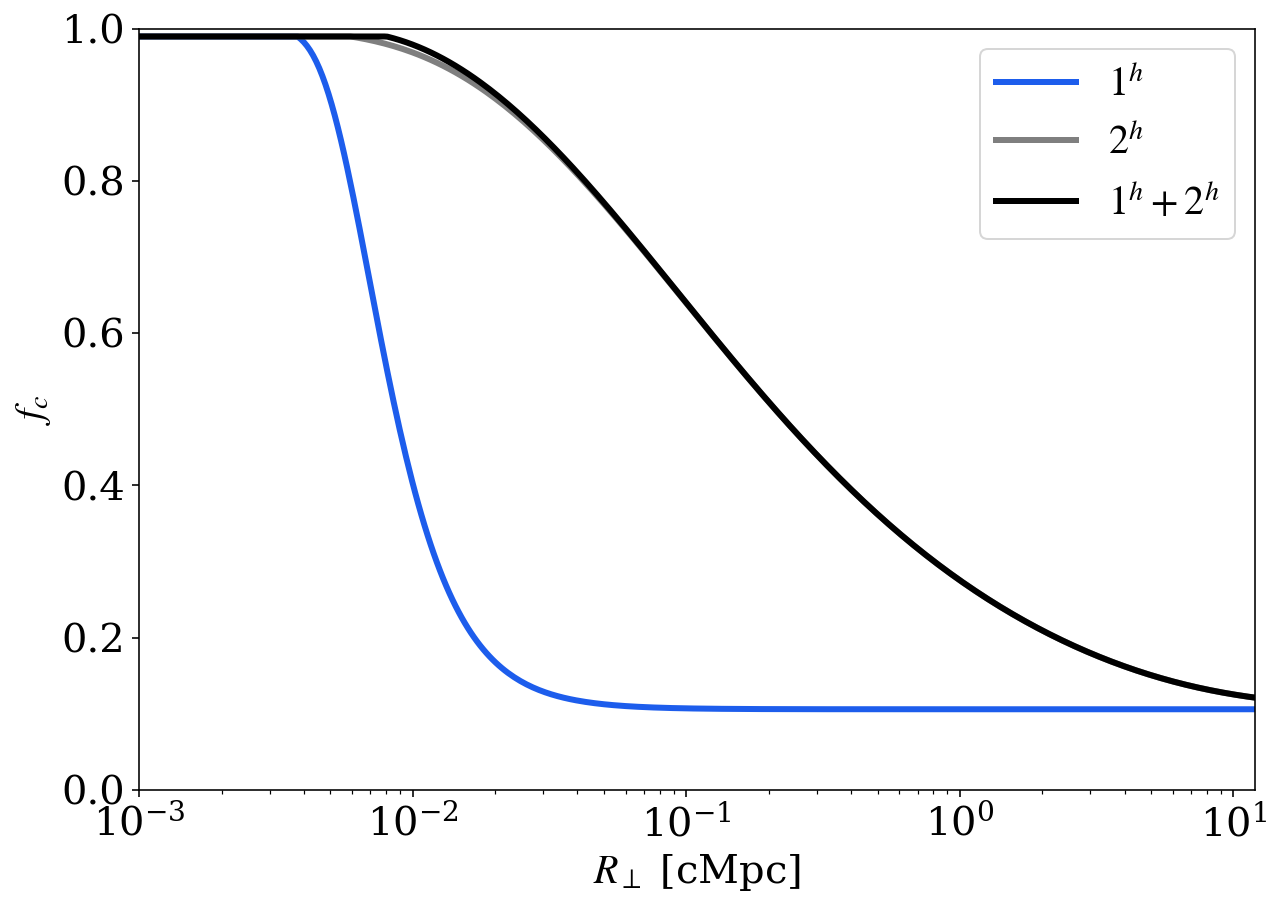

In [79]:
import matplotlib
plt.rcParams['mathtext.fontset']='stix'

# matplotlib.rcParams['font.sans-serif'] = "Times"
# matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 20

matplotlib.rcParams['font.serif'] = "DejaVu Serif"
matplotlib.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20

plt.figure(figsize=(10,7))
log = True

params = np.quantile(flat_samples, 0.5, axis=0)
params = new_flat[1420, :-1]
#params_low = np.quantile(flat_samples, 0.16, axis=0)
#params_hi = np.quantile(flat_samples, 0.84, axis=0)
theta = params

# these come from > 1 Mpc cgm3_check_dndz.ipynb
# twoh_params = [3.76863494,  1.60368843,  0.03840335,  1.25840737, 25.58740086]

toydata = make_grid_data(10.5, 0.1)
toymodel = Model(data=toydata)
toymodel.set_params(params)
fc_1h = toymodel.phit_1halo()
fc_2h = toymodel.phit_2halo()
fc_total = toymodel.phit_sum()

r_lin = toymodel.data[1]

plt.plot(r_lin, fc_1h, label=r'$1^{h}$', c='xkcd:azul', lw=3)
plt.plot(r_lin, fc_2h, label=r'$2^{h}$', c='tab:grey', lw=3)
plt.plot(r_lin, fc_total, label=r'$1^{h} + 2^{h}$', c='black', lw=3)
# plt.plot(r_lin, fc_2h_only, label='2_halo_only', c='black', ls='--', lw=3)
# plt.axvline(rcgm, lw=3, ls='--')
plt.ylim(0, 1)
# plt.xlim(0, 12)
if log:
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(1e-3, 12)
    #plt.ylim(-2, 1)
plt.ylabel(r"$f_c$")
plt.xlabel(r"$R_{\perp}$ [cMpc]")
plt.legend();

In [80]:
params

array([ 0.10102454,  3.48620517,  3.78891572,  1.54548075,  0.20820707,
        0.05407377,  1.17246551, 27.29891221])